<a href="https://colab.research.google.com/github/Erifai/NLP_TEXT_MINING_COVID_SEVERITY_FACTORS/blob/main/Code_new_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19 Severity Factors

### Authors :
        - Ryad Lotfi MAHTAL
        - Kamel MESBAHI
        - Ahmed Seyfeddine GOUMEIDA
        - Mohammed Erifai MAAMIR
### Supervisors : 
        - Mme Severine AFFELDT
        - Mr Lazhar LABIOD
### Objective :
        - This project aims first of all to identify the profiles of patients likely to develop a severe form of the cov-19 disease. In parallel to this work, it is also requested to identify the main comorbidities related to COVID19. More precisely, the aim is to identify predictive markers of interest for the severity of the disease

## Environnement Preparation

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json
#!pip install Bio
import Bio
from Bio import Entrez
from Bio import Medline
#!pip install matplotlib==3.2.0
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#----------------------------------------------
#Download the spacy bio parser
from IPython.utils import io
#with io.capture_output() as captured:
#    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz
#----------------------------
#import spacy.cli
##spacy.cli.download("en_core_web_lg")
#import en_core_web_lg
#nlp = en_core_web_lg.load()
#----------------------------
#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
#import en_core_sci_lg  # model downloaded in previous step
#--------------------------------------------------
#import nltk
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
#-----------------------------------------------------
#!pip install tqdm
import tqdm
#!pip install langdetect
import langdetect
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory
import seaborn as sns

In [11]:
#%matplotlib inline
#!pip install coclust
from scipy.io import loadmat
from sklearn.metrics import (adjusted_rand_score as ari,
                             normalized_mutual_info_score as nmi)
#!pip install coclust
from coclust.coclustering import (CoclustMod, CoclustSpecMod, CoclustInfo)
from coclust.io.data_loading import load_doc_term_data
from coclust.evaluation.internal import best_modularity_partition
#from coclust.evaluation.external import accuracy
from coclust.io.notebook import(input_with_default_int, input_with_default_str)
from coclust.visualization import (plot_max_modularities, 
                                   plot_intermediate_modularities,
                                   plot_cluster_top_terms, 
                                   get_term_graph, 
                                   plot_cluster_sizes)


from coclust.coclustering import CoclustMod
from coclust.io.data_loading import load_doc_term_data
from coclust.visualization import (plot_reorganized_matrix,
                                  plot_cluster_top_terms,
                                  plot_max_modularities,
                                  get_term_graph,
                                  plot_convergence)
from coclust.evaluation.internal import best_modularity_partition
from coclust.coclustering import CoclustMod
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

### Number of articles : 

In [ ]:
max_searchs = 10000
terms = "coronavirus covid covid19 severity hypertension"

In [ ]:
Entrez.email = 'A.N.Other@example.com'
ids=[[]]
print("max_searchs : ",max_searchs)
for i in range(0,max_searchs,100):
    print(i," ", end='')
    h = Entrez.esearch(db='pubmed', retmax=100,retstart=i, term=terms)
    result = Entrez.read(h)
    ids.append(result['IdList'])
h = Entrez.efetch(db='pubmed', id=ids, rettype='medline', retmode='json')
records = Medline.parse(h)

max_searchs :  10000
0  100  200  300  400  500  600  700  800  900  1000  1100  1200  1300  1400  1500  1600  1700  1800  1900  2000  2100  2200  2300  2400  2500  2600  2700  2800  2900  3000  3100  3200  3300  3400  3500  3600  3700  3800  3900  4000  4100  4200  4300  4400  4500  4600  4700  4800  4900  5000  5100  5200  5300  5400  5500  5600  5700  5800  5900  6000  6100  6200  6300  6400  6500  6600  6700  6800  6900  7000  7100  7200  7300  7400  7500  7600  7700  7800  7900  8000  8100  8200  8300  8400  8500  8600  8700  8800  8900  9000  9100  9200  9300  9400  9500  9600  9700  9800  9900  

### Data Transformation :

In [ ]:
# dict_ = {'paper_id': [], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}

def append_records(records):
    dict_ = {'paper_id': [], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
    for idx, entry in enumerate(records):

        if idx >max_searchs:
            break
        #--------------------------------------------------
        try:
            dict_['paper_id'].append(entry["PMID"])
        except Exception as e:
            dict_['paper_id'].append("")
        #--------------------------------------------------      
        try:
            dict_['abstract'].append(entry["AB"])
            # also create a column for the summary of abstract to be used in a plot
            if len(entry["AB"]) == 0: 
                # no abstract provided
                dict_['abstract_summary'].append("Not provided.")
            elif len(entry["AB"].split(' ')) > 100:
                # abstract provided is too long for plot, take first 100 words append with ...
                info = entry["AB"].split(' ')[:100]
                summary = get_breaks(' '.join(info), 40)
                dict_['abstract_summary'].append(summary + "...")
            else:
                # abstract is short enough
                summary = get_breaks(entry["AB"], 40)
                dict_['abstract_summary'].append(summary)
        except Exception as e:
            dict_['abstract'].append("")  
            dict_['abstract_summary'].append("Not provided.")

        #--------------------------------------------------      
        try:
            dict_['body_text'].append(entry["AB"])
        except Exception as e:
            dict_['body_text'].append("") 
        #--------------------------------------------------
        try:
            # if more than one author
            authors = entry['AU'][0].split(',')
            if len(authors) > 2:
                # if more than 2 authors, take them all with html tag breaks in between
                dict_['authors'].append(get_breaks('. '.join(authors), 40))
            else:
                # authors will fit in plot
                dict_['authors'].append(". ".join(authors))
        except Exception as e:
            # if only one author - or Null valie
            try : 
                dict_['authors'].append(entry['AU'][0])
            except Exception as e:
                dict_['authors'].append("")


        #-------------------------------------------------- 
        # add the title information, add breaks when needed
        try:
            title = get_breaks(entry['TI'][0], 40)
            dict_['title'].append(title)
        # if title was not provided
        except Exception as e:
            try:
                dict_['title'].append(entry['TI'][0])
            except Exception as e:
                dict_['title'].append("")
        #-------------------------------------------------- 
        # add the journal information
        try:
            dict_['journal'].append(entry['PT'][0])
        except Exception as e:
            dict_['journal'].append("")


    return dict_

In [ ]:
dict_1 = {'paper_id': [], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
print("max iterations : ",len(ids))
for i in range(1,len(ids)):
    h = Entrez.efetch(db='pubmed', id=ids[i], rettype='medline', retmode='json')
    records = Medline.parse(h)
    token = append_records(records)
    dict_1["paper_id"] = dict_1["paper_id"]+token["paper_id"]
    dict_1["abstract"] = dict_1["abstract"] + token["abstract"]
    dict_1["body_text"] =  dict_1["body_text"] +token["body_text"]
    dict_1["authors"] = dict_1["authors"] + token["authors"]
    dict_1["title"] =dict_1["title"] + token["title"]
    dict_1["journal"] =dict_1["journal"] +token["journal"]
    dict_1["abstract_summary"]=dict_1["abstract_summary"]+token["abstract_summary"]

max iterations :  101


In [ ]:
len(dict_1["paper_id"]),len(dict_1["abstract"]),len(dict_1["body_text"])  ,len(dict_1["authors"]) ,len(dict_1["title"]) ,len(dict_1["journal"]),len(dict_1["abstract_summary"])

(1255, 1255, 1255, 1255, 1255, 1255, 1255)

In [ ]:
df_covid = pd.DataFrame(dict_1, columns=['paper_id', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])

## Some feature engineering
Adding word count columns for both abstract and body_text can be useful parameters later:

In [ ]:
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))  # word count in abstract
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))  # word count in body
df_covid['body_unique_words']=df_covid['body_text'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body
df_covid.head()

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words
0,35490309,The consequences of SARS-CoV-2 infection inclu...,The consequences of SARS-CoV-2 infection inclu...,Parums DV,E,Editorial,The consequences of SARS-CoV-2 infection<br>i...,191,191,131
1,35481554,BACKGROUND & AIMS: Severe acute respiratory sy...,BACKGROUND & AIMS: Severe acute respiratory sy...,Kumar S,S,Journal Article,BACKGROUND & AIMS: Severe acute respiratory<b...,394,394,204
2,35476841,INTRODUCTION: Inherent differences as well as ...,INTRODUCTION: Inherent differences as well as ...,Pachpande V,D,Journal Article,INTRODUCTION: Inherent differences as well as...,275,275,169
3,35473558,OBJECTIVES: This study aims to further investi...,OBJECTIVES: This study aims to further investi...,Yao Y,P,Journal Article,OBJECTIVES: This study aims to further<br>inv...,243,243,152
4,35469713,BACKGROUND: The role of angiotensin-converting...,BACKGROUND: The role of angiotensin-converting...,Yoshihara F,R,Journal Article,BACKGROUND: The role of<br>angiotensin-conver...,255,255,148


## Handle Possible Duplicates

When we look at the unique values above, we can see that there are duplicates. It may have caused because of author submiting the article to multiple journals. Let's remove the duplicats from our dataset:

In [ ]:
df_covid.drop_duplicates(['abstract', 'body_text'], inplace=True)
df_covid['abstract'].describe(include='all')

count                                                  1132
unique                                                 1132
top       Diabetes is one of the most important comorbid...
freq                                                      1
Name: abstract, dtype: object

In [ ]:
df_covid['body_text'].describe(include='all')

count                                                  1132
unique                                                 1132
top       Diabetes is one of the most important comorbid...
freq                                                      1
Name: body_text, dtype: object

It looks like we didn't have duplicates. Instead, it was articles without Abstracts.

# Data Pre-processing

In [ ]:
df = df_covid

### Delete Null values   :

Now that we have our dataset loaded, we need to clean-up the text to improve any clustering or classification efforts. First, let's drop Null vales:

In [ ]:
df["body_text"].dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1132 entries, 0 to 1166
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             1132 non-null   object
 1   abstract             1132 non-null   object
 2   body_text            1132 non-null   object
 3   authors              1132 non-null   object
 4   title                1132 non-null   object
 5   journal              1132 non-null   object
 6   abstract_summary     1132 non-null   object
 7   abstract_word_count  1132 non-null   int64 
 8   body_word_count      1132 non-null   int64 
 9   body_unique_words    1132 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 97.3+ KB


### Handling multiple languages
Next we are going to determine the language of each paper in the dataframe. Not all of the sources are English and the language needs to be identified so that we know how handle these instances

In [ ]:
# set seed
DetectorFactory.seed = 0
# hold label - language
languages = []
# go through each text
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['body_text'].split(" ")
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e: 
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    # get the language    
    languages.append(lang)

100%|██████████| 1132/1132 [00:18<00:00, 60.72it/s]


In [ ]:
from pprint import pprint
languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang) 
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 1132

{'en': 1131, 'fr': 1}


Lets take a look at the language distribution in the dataset

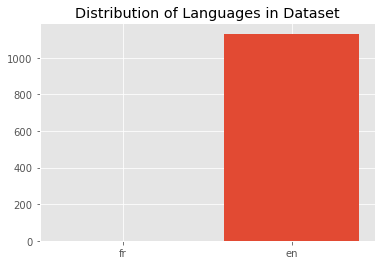

In [ ]:
df['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()


We will be dropping any language that is not English. Attempting to translate foreign texts gave the following problems:

1. API calls were limited

2. Translating the language may not carry over the true semantic meaning of the text


In [ ]:
df = df[df['language'] == 'en'] 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1131 entries, 0 to 1166
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             1131 non-null   object
 1   abstract             1131 non-null   object
 2   body_text            1131 non-null   object
 3   authors              1131 non-null   object
 4   title                1131 non-null   object
 5   journal              1131 non-null   object
 6   abstract_summary     1131 non-null   object
 7   abstract_word_count  1131 non-null   int64 
 8   body_word_count      1131 non-null   int64 
 9   body_unique_words    1131 non-null   int64 
 10  language             1131 non-null   object
dtypes: int64(3), object(8)
memory usage: 106.0+ KB


### Stopwords

Part of the preprocessing will be finding and removing stopwords (common words that will act as noise in the clustering step).

In [ ]:
import string
#punctuations
punctuations = string.punctuation
#stopwords
stopwords = list(STOP_WORDS)


Now the above stopwords are used in everyday english text. Research papers will often frequently use words that don't actually contribute to the meaning and are not considered everyday stopwords.


In [ ]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www' , 'the' , 'THE' ,"19" ,"-"]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

### Next lets create a function that will process the text data for us. 

#### Stop words , Ponctuation and Lemmatizing

In [ ]:
import spacy
import re
nlp = en_core_web_lg.load()
def spacy_process(texte):

    #URLs
    string = re.sub(r"https?://\S+|www.\S+",'',texte)
    #html 
    string = re.sub(r'<.*?>','',string)
    #Numbers
    string = re.sub(r'[0-9]+','',string) 

    mytokens = nlp(string)
    mytokens2 = [word.lemma_.lower().strip() for word in mytokens if word.pos_ != "PUNCT" and word.text.lower() not in stopwords and word.text.lower() not in punctuations]
    mytokens2 = " ".join([i for i in mytokens2])
    return mytokens2
df["processed_text"] = df["body_text"].apply(spacy_process)

<ipython-input-217-6ab7ca468df0>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["processed_text"] = df["body_text"].apply(spacy_process)


### Data Saving (to avoid data cleaning every time you load data)

In [ ]:
df["processed_text"].to_csv("./data_covid_hypertension/text_cleaned_hypertension_onlytext.csv")

In [ ]:
df.to_csv("./data_covid_hypertension/text_cleaned_hypertension_alldf.csv")

### Let's take a look at word count in the papers

C:\Users\moham\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    1131.000000
mean      261.469496
std        97.355655
min         0.000000
25%       209.500000
50%       251.000000
75%       288.500000
max      1112.000000
Name: body_word_count, dtype: float64

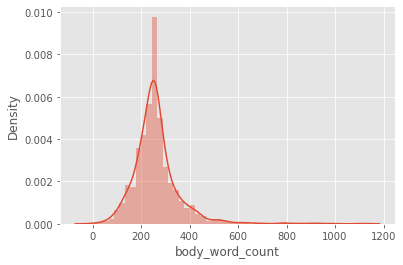

In [ ]:
sns.distplot(df['body_word_count'])
df['body_word_count'].describe()

C:\Users\moham\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    1131.000000
mean      163.179487
std        50.503418
min         0.000000
25%       137.000000
50%       159.000000
75%       181.000000
max       573.000000
Name: body_unique_words, dtype: float64

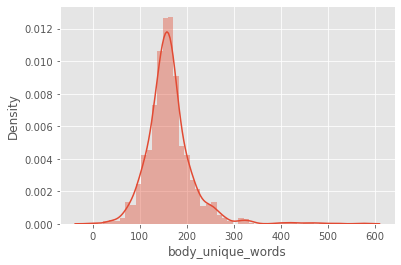

In [ ]:
sns.distplot(df['body_unique_words'])
df['body_unique_words'].describe()

## Data Loading (already cleaned data) 

In [468]:
import pandas as pd
df = pd.read_csv('./data_covid_asthma/text_cleaned_asthma_alldf.csv')
#df = pd.read_csv("/content/text_cleaned.csv")
df.drop(columns="Unnamed: 0",inplace=True)
df.dropna(inplace=True)

In [525]:
df

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,language,processed_text
0,35502514,"INTRODUCTION: It is not clear whether asthma, ...","INTRODUCTION: It is not clear whether asthma, ...",Aytekin ES,O,Journal Article,"INTRODUCTION: It is not clear whether asthma,...",321,321,189,en,introduction clear asthma frequent chronic dis...
1,35501222,"On March 11, 2020, the World Health Organizati...","On March 11, 2020, the World Health Organizati...",Chiner-Vives E,S,Journal Article,"On March 11, 2020, the World Health<br>Organi...",205,205,141,en,march world health organization declare corona...
2,35442470,OBJECTIVE: During the coronavirus disease 2019...,OBJECTIVE: During the coronavirus disease 2019...,Lee KH,P,Journal Article,OBJECTIVE: During the coronavirus disease<br>...,256,256,151,en,objective coronavirus disease covid- pandemic...
3,35438754,Importance: SARS-CoV-2 entry requires the TMPR...,Importance: SARS-CoV-2 entry requires the TMPR...,Nickols NG,E,Journal Article,Importance: SARS-CoV-2 entry requires the<br>...,448,448,275,en,importance sars cov- entry require tmprss cell...
4,35342017,BACKGROUND: Several chronic conditions have be...,BACKGROUND: Several chronic conditions have be...,Ludwig A,A,Journal Article,BACKGROUND: Several chronic conditions have<b...,272,272,175,en,background chronic condition associate high ri...
...,...,...,...,...,...,...,...,...,...,...,...,...
260,32396996,As a zoonotic disease that has already spread ...,As a zoonotic disease that has already spread ...,Azkur AK,I,Journal Article,As a zoonotic disease that has already spread...,362,362,207,en,zoonotic disease spread globally million human...
261,32389590,The novel coronavirus disease 2019 has rapidly...,The novel coronavirus disease 2019 has rapidly...,Maggi E,C,Journal Article,The novel coronavirus disease 2019 has rapidl...,167,167,111,en,novel coronavirus disease rapidly increase pa...
262,32294485,"BACKGROUND: In December 2019, the coronavirus ...","BACKGROUND: In December 2019, the coronavirus ...",Li X,R,Journal Article,"BACKGROUND: In December 2019, the coronavirus...",247,247,149,en,background december coronavirus disease covid...
263,32224232,"In the event of a global infectious pandemic, ...","In the event of a global infectious pandemic, ...",Shaker MS,C,Journal Article,"In the event of a global infectious pandemic,...",231,231,160,en,event global infectious pandemic drastic measu...


## Vectorisation (TF-IDF)

In [470]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text):
    
    global vectorizer 
    X = vectorizer.fit_transform(text)
    return X
#-----------------------------------------------------------
text = df['processed_text'].values
vectorizer = TfidfVectorizer(max_features= 2 ** 12)
X = vectorize(text)
X.shape

(264, 4004)

### Features names : 

In [471]:
# on doit vérifier si le vectorizer prend 2**12 premiers mots ou bien par nombre d'occurences 
all_terms_tfidf = vectorizer.get_feature_names()

# Coclustering

In [472]:
# ** Compute the final coClust modularity on a range of number of clusters **

# -- range of number of clusters
# ---- get min
min_cluster_nbr = 2
max_cluster_nbr = 9
range_n_clusters = range(min_cluster_nbr, (max_cluster_nbr+1))

# -- Number of random initialization per cluster number
n_rand_init = 1

# --  max modularity for all models
model, all_max_modularities = best_modularity_partition(X,range_n_clusters, n_rand_init)

Computing coclust modularity for a range of cluster numbers =
 2 ...
 3 ...
 4 ...
 5 ...
 6 ...
 7 ...
 8 ...
 9 ...
 All done !


### Number of Co-clusters

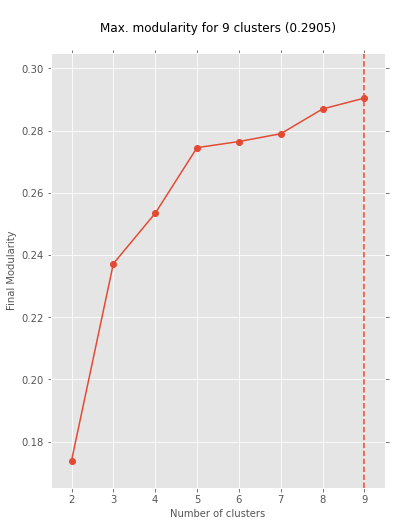

In [473]:
# ** Plot all final modularities **
plot_max_modularities(all_max_modularities, range_n_clusters)

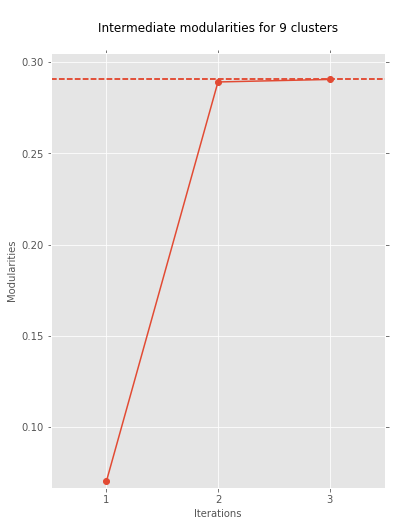

In [474]:
# ** Plot intermediate modularities for the best CoClust final modularity **
plot_intermediate_modularities(model)

## Co-clusters Mining

### Top frequent words & co-clusters sizes

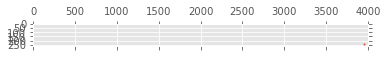

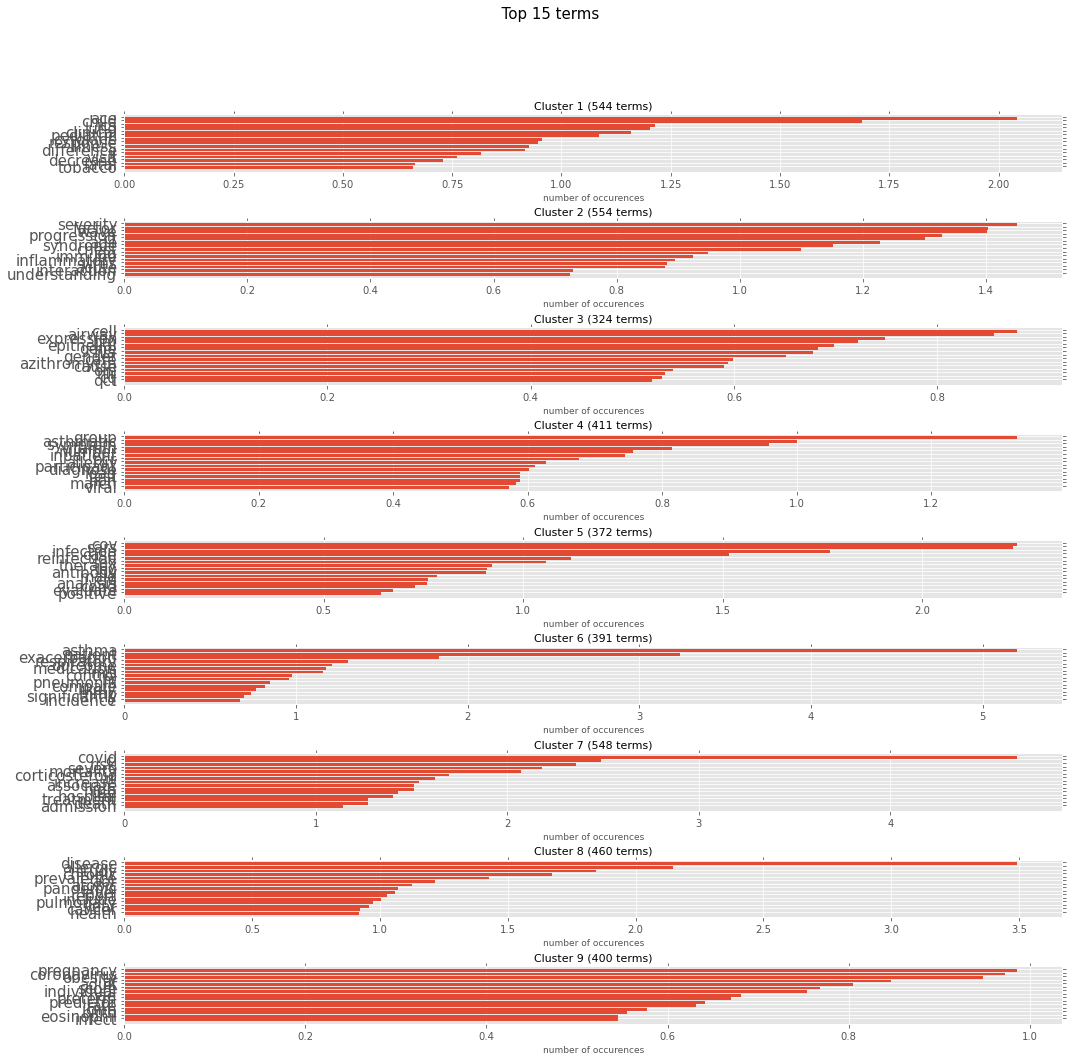

taille de chaque cluster :


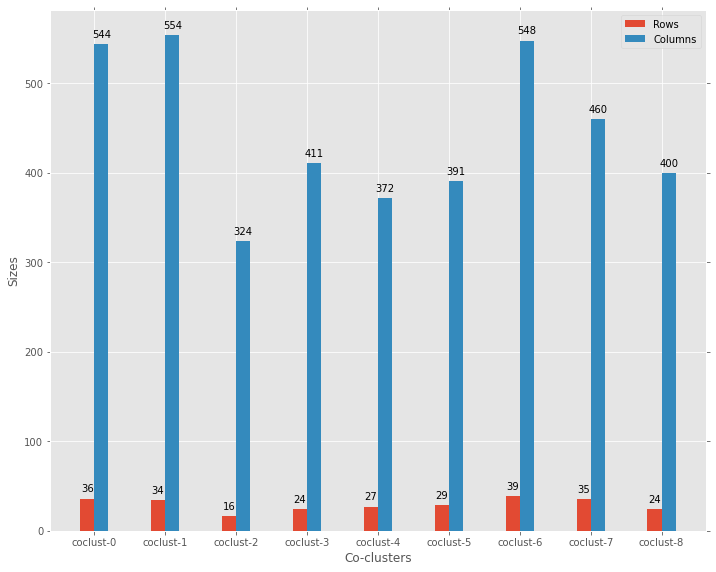

In [475]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,8)

from coclust.visualization import (plot_reorganized_matrix,
                                  plot_cluster_top_terms,
                                  plot_max_modularities,
                                  get_term_graph,
                                  plot_convergence)
# ** Plot top terms for each cluster and the cluster sizes **
n_terms = 15
# plot the reorganized matrix

plot_reorganized_matrix(X, model, markersize=0.9)
# --> top terms
list_df = plot_cluster_top_terms(X, all_terms_tfidf, n_terms, model)
# --> cluster sizes
print("taille de chaque cluster :")
plot_cluster_sizes(model)

In [476]:
#for i in range(1,len(list_df)+1):
#    df_tmp = list_df[i-1]
#    df_tmp.to_csv("./data_covid_asthma/top_words_asthma_cocluster_"+str(i)+".csv",columns = df_tmp.columns,index=False)

## NER (NAMED ENTITY RECOGNITION)

### Searching desease names in every co-cluster

In [478]:
#!pip install --user https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bc5cdr_md-0.4.0.tar.gz
import en_ner_bc5cdr_md
nlp = spacy.load("en_ner_bc5cdr_md")

In [128]:
#nlp = spacy.load("en_ner_bc5cdr_md")
clusters_terms=[]
for i in range(0,model.n_clusters):
    row_indices, col_indices = model.get_indices(i)
    clusters_terms.append(np.array(all_terms_tfidf)[col_indices])

In [129]:
deseases_per_cluster=  {}
desease=[]

for j in range(0,len(clusters_terms)):
    for i in clusters_terms[j]:
        doc = nlp(str(i))  
        word = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
        if len(word)!=0 : desease.append(word[0])
    deseases_per_cluster[j] =desease
    print("TERM_LIST ",j, " : " ,desease)
    desease=[]
 

TERM_LIST  0  :  ['anomaly', 'apnea', 'atherosclerosis', 'diarrhea', 'dyspnea', 'eosinopenia', 'erythema', 'fibrosis', 'fracture', 'ischemia', 'kawasaki', 'lethargy', 'malnutrition', 'morbilliform', 'necrotic', 'pruritus', 'purpuric', 'vasculitis']
TERM_LIST  1  :  ['angioedema', 'bronchiolitis', 'bronchitis', 'desaturation', 'diarrhoea', 'fever', 'headache', 'lymphopenia', 'necrosis', 'pes', 'pneumothorax', 'poisoning', 'sore', 'stomachache', 'sympotomatic', 'throat', 'trauma', 'tumor']
TERM_LIST  2  :  ['anorexia', 'arthritis', 'bradyarrhythmia', 'epilepsy', 'hla', 'nervosa', 'palsy', 'tumour']
TERM_LIST  3  :  ['allergy', 'anaphylaxis', 'anemia', 'htn', 'hypercholesterolemia', 'hyperlipidemia', 'hypersensitivity', 'hypocalcemia', 'nausea', 'ricket', 'thrombocytopenia', 'urticaria']
TERM_LIST  4  :  ['ageusia', 'anosmia', 'bradycardia', 'cardiopathy', 'dyspnoea', 'eosinophilia', 'febrile', 'lymphocytopenia', 'puberty']
TERM_LIST  5  :  ['alopecia', 'canada', 'coagulopathy', 'coma', '

In [130]:
for i in range(1,len(deseases_per_cluster)+1):
    text = " ".join(word for word in deseases_per_cluster[i-1])
    word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
    word_cloud.to_file("./data_covid_asthma/NER_asthma_cocluster_"+str(i)+".png")
    #------
    df_tmp = pd.DataFrame(deseases_per_cluster[i-1],columns =['DESEASE'])
    df_tmp.to_csv("./data_covid_asthma/NER_asthma_cocluster_"+str(i)+".csv",columns = df_tmp.columns,index=False)

## Similarity Graph

In [416]:
import json

def save_pet(filename,pet):
    with open(filename, 'w') as f:
        f.write(json.dumps(pet))
        
#---------------------------------

def load_pet(filename):
    with open(filename) as f:
        pet = json.loads(f.read())
    return pet


In [177]:
for i in range(1,model.n_clusters+1):
    print("./data_covid_obesity/graph_obesity_cocluster_"+str(i))

./data_covid_obesity/graph_obesity_cocluster_1
./data_covid_obesity/graph_obesity_cocluster_2
./data_covid_obesity/graph_obesity_cocluster_3
./data_covid_obesity/graph_obesity_cocluster_4


In [238]:
nb_voisin = 3
nb_top_words = 15
for i in range(1,model.n_clusters+1):
    graph = get_term_graph(X,model, all_terms_tfidf, i-1, nb_top_words, nb_voisin)
    for j in range(len(graph["nodes"])):
        doc = nlp(str(graph["nodes"][j]["name"]))
        if len(doc.ents) != 0:
            if doc.ents[0].label_ == "DISEASE":
                graph["nodes"][i]["group"] = 2
    save_pet("./data_covid_asthma/graph_asthma_cocluster_"+str(i),graph)

In [519]:
# ** Plot the term graph for a given cluster of terms **
graph = get_term_graph(X,model, all_terms_tfidf, 8, 15, 3)

In [520]:
for i in range(len(graph["nodes"])):
    doc = nlp(str(graph["nodes"][i]["name"]))
    if len(doc.ents) != 0:
        if doc.ents[0].label_ == "DISEASE":
            graph["nodes"][i]["group"] = 2

In [521]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min'
  }
});

<IPython.core.display.Javascript object>

In [522]:
 from IPython.display import Javascript
 #runs arbitrary javascript, client-side
 Javascript("""
            window.graph={};
            """.format(graph))

<IPython.core.display.Javascript object>

In [523]:
%%javascript
 require(['d3'], function(d3){
   //a weird idempotency thing
   $("#chart1").remove();
   //create canvas
   element.append("<div id='chart1'></div>");
   $("#chart1").width("1160px");
   $("#chart1").height("800px");        
   var margin = {top: 20, right: 20, bottom: 30, left: 40};
   var width = 1280 - margin.left - margin.right;
   var height = 800 - margin.top - margin.bottom;
   var svg = d3.select("#chart1").append("svg")
     .style("position", "relative")
     .style("max-width", "960px")
     .attr("width", width + "px")
     .attr("height", (height + 50) + "px")
     .call(d3.behavior.zoom().on("zoom", redraw))
     .append("g")
     .attr("transform", "translate(" + margin.left + "," + margin.top + ")");
    
    
   function redraw() {
       svg.attr("transform",
                "translate(" + d3.event.translate + ")"
                + " scale(" + d3.event.scale + ")");
   }   
   var color = d3.scale.category20();
   var force = d3.layout.force()
     .charge(-500)
     //.linkDistance(5)
     .linkDistance(function(d) { return (1 - d.value); })
     .size([width, height]);
   var graph = window.graph;
   
   force
       .nodes(graph.nodes)
       .links(graph.links)
       .start();

   var link = svg.selectAll(".link")
       .data(graph.links)
       .enter().append("line")
       .attr("class", "link")
       .style("stroke", "#999;")
       .style("stroke-opacity", .6)
       .style("stroke-width", function(d) { return Math.sqrt(d.value); })
 
       .style("stroke", "blue");
   var node = svg.selectAll(".node")
       .data(graph.nodes)
       .enter().append("g")
       .attr("class", "node")
       .call(force.drag);
   
   node.append("circle")
       .attr("class", "node_circle")
       .attr("r", 8)
       .style("fill", function(d) { if (d.group == "2") {return "red";} else{return color(d.group);} });
   node.append("text")
       .attr("class", "node_text")
       .attr("dx", 12)
       .attr("dy", ".35em")
       .text(function(d) { return d.name });
   node.append("title")
       .text(function(d) { return d.name; });
   var node_text = svg.selectAll(".node_text");
   var node_circle = svg.selectAll(".node_circle");
   
   force.on("tick", function() {
     link.attr("x1", function(d) { return d.source.x; })
         .attr("y1", function(d) { return d.source.y; })
         .attr("x2", function(d) { return d.target.x; })
         .attr("y2", function(d) { return d.target.y; });
     node_circle.attr("cx", function(d) { return d.x; })
         .attr("cy", function(d) { return d.y; });
     
     node_text.attr("x", function(d) { return d.x; })
         .attr("y", function(d) { return d.y; });
   });
       
 });

<IPython.core.display.Javascript object>

## DATAVIZ (APP Streamlit ) : 

In [2]:
!pip install streamlit
from google.colab import drive
drive.mount('/content/drive')

In [8]:
%%writefile app.py
from os import sep
import streamlit as st
from datetime import datetime
import streamlit as st
from vega_datasets import data
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

#--------------------------------------------------------------------------------
st.set_page_config(layout="wide", page_icon="microbe", page_title="Covid19 Severity app")
st.title("🦠 Covid-19 severity factors")
st.sidebar.title(" 🦠 Covid-19 severity factors")

with st.expander("ℹ️ - About this app", expanded=False):

    st.write(
        """     
Ce projet vise tout d’abord à identifier les profils de patients susceptibles de développer une forme grave de la maladie. Parallèlement à ce travail, il est également demander d’identifier les comorbidités principales en lien avec la COVID19. Plus précisémment, il s’agit d’identifier des marqueurs de prédictions d’intérêt pour la sévérité de la maladies
-   (1) Ce PPD a pour premier objectif d’analyser une corpus biomédical autour de la COVID19, et plus particulièrement des comorbidités et des facteurs de sévérité de la maladie.
-   (2) Le second objectif de ce projet est l’exploitation d’approche de fouille de texte et de NLP pour l’identification de ces facteurs et de leurs interactions..
	    """
    )
    
st.markdown("")
st.markdown("## 📄 Articles : ")
#--------------------------------------------------------------------------------
#--------------------------------Functions---------------------------------------
#--------------------------------------------------------------------------------

def space(num_lines=1):
    """Adds empty lines to the Streamlit app."""
    for _ in range(num_lines):
        st.write("")

#---------------------------------------------------------------------------------
# Key words
option = st.sidebar.selectbox(
     'Choose words to creat dataset :',
     #('Covid19 & Severity',
      ('Covid19 & Severity & Obesity',
      'Covid19 & Severity & Asthma',
      'Covid19 & Severity & Cancer',
      'Covid19 & Severity & Pneumonia',
      'Covid19 & Severity & Diabetes',
      'Covid19 & Severity & Hypertension')
     )
st.sidebar.write('You selected   :', option)

#---------------------------------------------------------------------------------
# number of articles to fetch
nb = st.sidebar.slider('choose the number of articles to fetch', 0,10000,500)
st.sidebar.write("You choosed    :", nb, ' articles')
space(1)

#--------------------------------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------"Covid19 & Severity & Asthma"-----------------------------------------------------------
#--------------------------------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------------------------------
  
if (option=="Covid19 & Severity & Asthma"):
    df = pd.read_csv("/content/drive/MyDrive/PPD 2022/Datasets/Covid19 & Severity & Asthma/text_cleaned_asthma_alldf.csv") 
    df.drop(columns="Unnamed: 0",inplace=True) 
    linkTopWords = "/content/drive/MyDrive/PPD 2022/Datasets/Covid19 & Severity & Asthma/top_words_asthma_cocluster_"
    nbClusters = 9
    expander = st.expander("See all articles :", expanded=True)
    with expander:
    st.dataframe(df.head(nb))
    #--------------------------------------------------------------------------------------------------------------------------------
    st.header("")
    st.markdown("## 📊 Clusters : ")
    expander = st.expander("Clusters size :", expanded=False)
    with expander:
    image = st.image("/content/drive/MyDrive/PPD 2022/Datasets/Covid19 & Severity & Asthma/clusters_size_asthma.png")
    selectedCluster = st.selectbox('Select the cluster number  :',('1', '2', '3','4','5','6','7','8','9'))
    linkSimilarity = "/content/drive/MyDrive/PPD 2022/Datasets/Covid19 & Severity & Asthma/clusters_size_asthma.png"
    linkNER = "/content/drive/MyDrive/PPD 2022/Datasets/Covid19 & Severity & Asthma/clusters_size_asthma.png"
#--------------------------------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------"Covid19 & Severity & Cancer"-----------------------------------------------------------
#--------------------------------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------------------------------  
elif (option=="Covid19 & Severity & Cancer"):
    df = pd.read_csv("/content/drive/MyDrive/PPD 2022/Datasets/Covid19 & Severity & Cancer/text_cleaned_cancer_alldf.csv")  
    linkTopWords = "/content/drive/MyDrive/PPD 2022/Datasets/Covid19 & Severity & Cancer/top_words_cancer_cocluster_"
    nbClusters = 3
    df.drop(columns="Unnamed: 0",inplace=True)
    expander = st.expander("See all articles :", expanded=True)
    with expander:
    st.dataframe(df.head(nb))
    #--------------------------------------------------------------------------------------------------------------------------------
    st.header("")
    st.markdown("## 📊 Clusters : ")
    expander = st.expander("Cluster sizes :", expanded=False)
    with expander:
    image = st.image("/content/drive/MyDrive/PPD 2022/Datasets/Covid19 & Severity & Cancer/clusters_size_cancer.png")
    selectedCluster = st.selectbox('Select the cluster number  :',('1', '2', '3'))
    linkSimilarity = "/content/drive/MyDrive/PPD 2022/Datasets/Covid19 & Severity & Cancer/clusters_size_cancer.png"
    linkNER = "/content/drive/MyDrive/PPD 2022/Datasets/Covid19 & Severity & Cancer/clusters_size_cancer.png"

#--------------------------------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------"Covid19 & Severity & Diabetes"-----------------------------------------------------------
#--------------------------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------------- 
elif (option=="Covid19 & Severity & Diabetes"):
    df = pd.read_csv("/content/drive/MyDrive/PPD 2022/Datasets/Covid19 & Severity & Diabetes/text_cleaned_diabetes_alldf.csv")
    linkTopWords = "/content/drive/MyDrive/PPD 2022/Datasets/Covid19 & Severity & Diabetes/top_words_diabetes_cocluster_"
    nbClusters = 5  
    df.drop(columns="Unnamed: 0",inplace=True)
    expander = st.expander("See all articles :", expanded=True)
    with expander:
    st.dataframe(df.head(nb))
    #--------------------------------------------------------------------------------------------------------------------------------
    st.header("")
    st.markdown("## 📊 Clusters : ")
    expander = st.expander("Cluster sizes :", expanded=False)
    with expander:
    image = st.image("/content/drive/MyDrive/PPD 2022/Datasets/Covid19 & Severity & Diabetes/clusters_size_diabetes.png")
    selectedCluster = st.selectbox('Select the cluster number  :',('1', '2', '3','4','5'))
    linkSimilarity = "/content/drive/MyDrive/PPD 2022/Datasets/Covid19 & Severity & Diabetes/clusters_size_diabetes.png"
    linkNER =  "/content/drive/MyDrive/PPD 2022/Datasets/Covid19 & Severity & Diabetes/clusters_size_diabetes.png"

#--------------------------------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------"Covid19 & Severity & Hypertension"-----------------------------------------------------------
#--------------------------------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------------------------------
elif (option=="Covid19 & Severity & Hypertension"):
    df = pd.read_csv("/content/drive/MyDrive/PPD 2022/Datasets/Covid19 & Severity & Hypertension/text_cleaned_hypertension_alldf.csv")
    linkTopWords = "/content/drive/MyDrive/PPD 2022/Datasets/Covid19 & Severity & Hypertension/top_words_hypertension_cocluster_"
    nbClusters = 5
    df.drop(columns="Unnamed: 0",inplace=True)
    expander = st.expander("See all articles :", expanded=True)
    with expander:
    st.dataframe(df.head(nb))
    #--------------------------------------------------------------------------------------------------------------------------------
    st.header("")
    st.markdown("## 📊 Clusters : ")
    expander = st.expander("Cluster sizes :", expanded=False)
    with expander:
    image = st.image("/content/drive/MyDrive/PPD 2022/Datasets/Covid19 & Severity & Hypertension/clusters_size_hypertension.png")
    selectedCluster = st.selectbox('Select the cluster number  :',('1', '2', '3','4','5'))
    linkSimilarity = "/content/drive/MyDrive/PPD 2022/Datasets/Covid19 & Severity & Hypertension/clusters_size_hypertension.png"
    linkNER = "/content/drive/MyDrive/PPD 2022/Datasets/Covid19 & Severity & Hypertension/clusters_size_hypertension.png"

#--------------------------------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------"Covid19 & Severity & Obesity"-----------------------------------------------------------
#--------------------------------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------------------------------  
elif (option=="Covid19 & Severity & Obesity"):
    df = pd.read_csv("/content/drive/MyDrive/PPD 2022/Datasets/Covid19 & Severity & Obesity/text_cleaned_obesity_alldf.csv")  
    linkTopWords = "/content/drive/MyDrive/PPD 2022/Datasets/Covid19 & Severity & Obesity/top_words_obesity_cocluster_"
    nbClusters = 4
    df.drop(columns="Unnamed: 0",inplace=True)
    expander = st.expander("See all articles :", expanded=True)
    with expander:
    st.dataframe(df.head(nb))
    #--------------------------------------------------------------------------------------------------------------------------------
    st.header("")
    st.markdown("## 📊 Clusters : ")
    expander = st.expander("Cluster sizes :", expanded=False)
    with expander:
    image = st.image("/content/drive/MyDrive/PPD 2022/Datasets/Covid19 & Severity & Obesity/clusters_size_obesity.png")
    selectedCluster = st.selectbox('Select the cluster number  :',('1', '2', '3','4'))
    linkSimilarity = "/content/drive/MyDrive/PPD 2022/Datasets/Covid19 & Severity & Obesity/clusters_size_obesity.png"
    linkNER = "/content/drive/MyDrive/PPD 2022/Datasets/Covid19 & Severity & Obesity/clusters_size_obesity.png"

#--------------------------------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------"Covid19 & Severity & Pneumonia"-----------------------------------------------------------
#--------------------------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------------- 
elif (option=="Covid19 & Severity & Pneumonia"):
    df = pd.read_csv("/content/drive/MyDrive/PPD 2022/Datasets/Covid19 & Severity & Pneumonia/text_cleaned_pneumonia_alldf.csv")
    linkTopWords = "/content/drive/MyDrive/PPD 2022/Datasets/Covid19 & Severity & Pneumonia/top_words_pneumonia_cocluster_"
    nbClusters = 5  
    df.drop(columns="Unnamed: 0",inplace=True)
    expander = st.expander("See all articles :", expanded=True)
    with expander:
    st.dataframe(df.head(nb))
    #--------------------------------------------------------------------------------------------------------------------------------
    st.header("")
    st.markdown("## 📊 Clusters : ")
    expander = st.expander("Cluster sizes :", expanded=False)
    with expander:
    image = st.image("/content/drive/MyDrive/PPD 2022/Datasets/Covid19 & Severity & Pneumonia/clusters_size_pneumonia.png")
    selectedCluster = st.selectbox('Select the cluster number  :',('1', '2', '3','4','5'))
    linkSimilarity = "/content/drive/MyDrive/PPD 2022/Datasets/Covid19 & Severity & Pneumonia/clusters_size_pneumonia.png"
    linkNER = "/content/drive/MyDrive/PPD 2022/Datasets/Covid19 & Severity & Pneumonia/clusters_size_pneumonia.png"
#----------------------------------------------------------------------------------------------------------------------------
st.markdown("")
st.sidebar.write('You selected   :', option)
#----------------------------------------------------------------------------------------------------------------------------
c1, c2= st.columns([4,6])
expander = st.expander("See plot :")
with expander:
    link = linkTopWords+str(selectedCluster)+".csv"
    cluster = pd.read_csv(link)
    cluster = cluster.sort_values(by=['count'],ascending=False)
    #---------------------------------------------------------
    fig = plt.figure(figsize=(8, 2))
    ax = sns.barplot(x="words", y="count", data=cluster.head(20), alpha=0.9)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
    with expander:
    c1.write(cluster)
    with expander:
    c2.pyplot(fig)
#----------------------------------------------------------------------------------------------------------------------------
st.header("")
st.markdown("## 🧬 Similarities : ")
expander2 = st.expander("Similarities  :", expanded=False)
with expander2:
    image2 = st.image(linkSimilarity)
#----------------------------------------------------------------------------------------------------------------------------
st.header("")
st.markdown("## 📌 NER Named Entity Recognition : ")
expander3 = st.expander("Similarities  :", expanded=False)
with expander3:
    image3 = st.image(linkNER)

#----------------------------------------------------------------------------------------------------------------------------
st.markdown("## 📥 Download Datasets and results :")
def convert_df(df):
     # IMPORTANT: Cache the conversion to prevent computation on every rerun
    return df.to_csv(sep=";").encode('utf-8')
dfcsv = convert_df(df)
clusterdf = convert_df(cluster)
c1, c2= st.columns([6, 6])
with c1:
    st.header("Dataset :")
    result = st.download_button(
      label="📥 Download (.csv)",
      data=dfcsv,
      file_name=option+'_df.csv',
      mime='text/csv',
    )
with c2:
    st.header("Cluster :")
    dataset = st.download_button(
      label="📥 Download(.csv)",
      data=clusterdf,
      file_name=option+selectedCluster+'_df.csv',
      mime='text_/csv',
    )

Writing app.py


In [1]:
!streamlit run app.py & npx  localtunnel --port 8501